# Intro zu Diffusion-Models

<small>(Basierend auf andrewkchan's [Diffusion Models blog post](https://andrewkchan.dev/posts/diffusion.html), welcher wiederum von tanelp's [tiny-diffusion](https://github.com/tanelp/tiny-diffusion) inspiriert ist.)</small>

Wir trainieren hier mehrere kleine diffusion models, um eine 2D-Datenverteilung ("Datasaurus") zu lernen. Wir lernen dabei ein paar Standard-Techniken und sehen, wieso diese eingesetzt werden.

Dieses Notebook sollte auch auf der CPU in annehmbarer Zeit durchlaufen, also braucht ihr hier keine GPU :)

### Dataset laden

Wir laden als Erstes unser Dataset, was eine Menge von Punkten in 2D ist, also $\{x_i\}_{i=1}^{N}, x_i \in \mathbb{R}^2$.

Zusammen sehen die Punkte aus wie die Outline eines T-Rex. Diese Verteilung werden wir im Folgenden mit einem neuronalen Netz (diffusion model) modellieren.

In [ ]:
import os, sys
import torch

import tqdm.notebook as tqdm
from pathlib import Path
import pickle, gzip, math, os, time, shutil, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
import ipywidgets as widgets
from matplotlib.collections import LineCollection
%matplotlib inline

def todo():
    raise NotImplementedError("In dieser Zelle gibt es noch mindestens ein TODO!")

df = pd.read_csv('datasaurus.tsv',sep='\t')
plt.figure(figsize=(4,4))
datasaurus = np.asarray(df[df['dataset'] == 'dino'][['x','y']].values, dtype=float).reshape(-1,2)
plt.scatter(datasaurus[:,0], datasaurus[:,1])

### Der Vorwärts-Prozess (noising process)

Wie sieht unser Datensatz entlang des Vorwärts-Prozesses aus, wenn mehr und mehr Noise hinzugefügt wird? Wir sehen uns ein paar Zeitpunkte entlang des Prozesses visuell an.

**Aufgabe**: Implementiert dazu die Funktion `get_diffusion_parameters` selbst.
  * Es gibt hier ein $\beta_t$, das wir auf den Folien unterschlagen haben, welches aber im DDPM-Formalismus üblich ist. Es gilt aber der simple Zusammenhang:
  * (1) $\alpha_t := 1 - \beta_t$ für alle $t$.
  * (2) `beta` soll linear von `beta_min` bis `beta_max` laufen.
  * (3) `alpha_bar` ist das kumulative Produkt von `alpha`, also $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$.

Der Plot sollte dann so aussehen:<br>
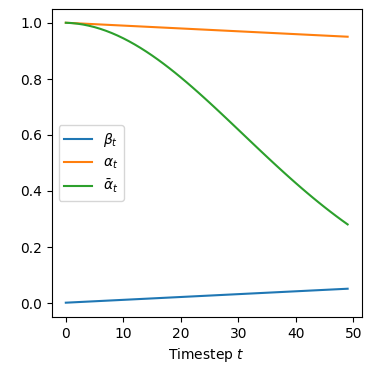

**Hinweis**: Für Schritt 2 und Schritt 3 gibt's schon eine passende vorgefertigte Funktion in PyTorch.

In [ ]:
trex_viz_path = Path("trex_viz")
trex_viz_path.mkdir(exist_ok=True)


def get_diffusion_parameters(beta_min, beta_max, T):
    
    ### PARTICIPANT TODO
    
    betas = todo()
    alphas = todo()
    alpha_bars = todo()
    
    ### END PARTICIPANT TODO
    
    return betas, alphas, alpha_bars


T = 50
betas, alphas, alpha_bars = get_diffusion_parameters(beta_min=0.0001, beta_max=0.05, T=T)

plt.figure(figsize=[4, 4])
plt.plot(torch.arange(T), betas, label=r'$\beta_t$')
plt.plot(torch.arange(T), alphas, label=r'$\alpha_t$')
plt.plot(torch.arange(T), alpha_bars, label=r'$\bar{\alpha}_t$')
plt.xlabel('Timestep $t$')
plt.ylim(-0.05,1.05)
plt.legend()
plt.savefig(trex_viz_path/f"schedule_original.svg")
plt.show()

In [ ]:
def forward_noise_dataset(dataset, beta_min, beta_max, T):
    betas, alphas, alpha_bars = get_diffusion_parameters(beta_min=beta_min, beta_max=beta_max, T=T)

    s = dataset
    series=[s]
    for t in range(T):
        noise = torch.randn_like(dataset)
        series.append(series[-1] * alpha_bars[t].sqrt() + (1 - alphas[t]).sqrt() * noise)
    return series

# We normalize our data for better training: zero mean and unit variance (z-normalization)
datasaurus_tensor = torch.tensor(datasaurus)
datasaurus_tensor = (datasaurus_tensor - datasaurus_tensor.mean()) / datasaurus_tensor.std()
# Repeat our dataset 6 times just so we get more points for visualization
trex_viz_input = torch.cat(
    (datasaurus_tensor, datasaurus_tensor, datasaurus_tensor, datasaurus_tensor, datasaurus_tensor, datasaurus_tensor),
    dim=0
)
# Apply different levels of noise
T = 50
datasaurus_series = forward_noise_dataset(trex_viz_input, beta_min=0.0001, beta_max=0.05, T=T)

# Scatterplot select levels of noise
def scatters(cols, rows, datasets, labels, width=14):
    figure = plt.figure(figsize=(width, rows/cols*width))
    for i in range(cols * rows):
        dataset, label = datasets[i], labels[i]
        figure.add_subplot(rows, cols, i+1)
        plt.title(label)
        plt.axis("off")
        plt.scatter(dataset[:,0], dataset[:,1],s=15,alpha=0.5)
    plt.show()

for i in range(len(datasaurus_series)):
    data = datasaurus_series[i]
    plt.figure(figsize=[6, 6])
    plt.scatter(data[:,0], data[:,1],s=15,alpha=0.5)
    plt.axis('off')
    plt.savefig(trex_viz_path/f"step{i:03d}.svg")
    plt.close()

display_ts = [0, 6, 12, 25, 50]
scatters(len(display_ts), 1, [datasaurus_series[i] for i in display_ts], [f"t={display_ts[i]}" for i in range(len(display_ts))])

### Der Rückwärts-Prozess (reverse/denoising process)

Der *reverse process* sollte uns von noise zu Datenpunkten führen. Grob gesagt lassen wir hier die aus einer einfachen Verteilung (Standard-Gaussverteilung) ursprünglich gesampelten Punkte nach und nach den Vektorfeldern (sog. "drift vector fields") folgen, die zu unseren Trainingsdaten gehören. Zusätzlich fügen wir in jedem Schritt entlang des reverse process neuen Noise ein. Das ist nicht strikt notwendig, aber dazu später mehr.

Diese drift vector fields beschreiben die über alle Datenpunkte gemittelt durchschnittliche Richtung, in die ein Punkt zum aktuellen Zeitpunkt laufen sollte, um näher zu einem Datenpunkt zu gelangen. Sie stellen die Größe dar, die unser diffusion model am Ende lernen soll. Wir können sie auch zu verschiedenen Zeitpunkten mit verschiedenen Noise-Levels ansehen:

In [ ]:
def drift_grids(dataset, beta_min, beta_max, T, xrange=(-2,2,0.15), yrange=(-2,2,0.15)):
    X,Y = np.meshgrid(np.arange(*xrange),np.arange(*yrange))
    XY=torch.tensor(np.stack((X,Y),axis=-1))
    betas, alphas, alpha_bars = get_diffusion_parameters(beta_min=beta_min, beta_max=beta_max, T=T)

    dataset_grid = torch.tensor(np.full(XY.shape[:-1] + dataset.shape, dataset))
    s=torch.zeros_like(XY)
    series=[s]
    for t in range(T):
        alpha_bars_t1 = alpha_bars[t-1] if t>0 else torch.tensor(1.)
        xts = XY[:,:,None,:] # [xlen,ylen,1,2]
        x0s = dataset_grid # [xlen,ylen,N,2]
        mus = (alphas[t].sqrt()*(1-alpha_bars_t1)*xts + alpha_bars_t1.sqrt()*(1-alphas[t])*x0s)/(1-alpha_bars[t]) # [xlen,ylen,N,2]
        weights = torch.exp(-(torch.linalg.vector_norm(xts-alpha_bars[t].sqrt()*x0s, ord=2, dim=-1)/(1-alpha_bars[t]))/2) # [xlen,ylen,N]
        weights = weights / torch.sum(weights, dim=2, keepdim=True)
        mus = torch.sum(mus*weights[...,None], dim=2) # [xlen,ylen,2]
        drift = mus - xts.reshape(mus.shape) # [xlen,ylen,2]
        series.append(drift.numpy())
    return series

def quivers(cols, rows, datasets, labels, width=14, xrange=(-2,2,0.15), yrange=(-2,2,0.15)):
    X,Y = np.meshgrid(np.arange(*xrange),np.arange(*yrange))
    figure = plt.figure(figsize=(width, rows/cols*width))
    for i in range(cols * rows):
        dataset, label = datasets[i], labels[i]
        figure.add_subplot(rows, cols, i+1)
        plt.title(label)
        plt.axis("off")
        plt.quiver(X, Y, dataset[:,:,0], dataset[:,:,1])
    plt.show()

xrange=(-2,2,0.15)
yrange=(-2,2,0.15)
datasaurus_drift = drift_grids(datasaurus_tensor, beta_min=0.0001, beta_max=0.05, T=50, xrange=xrange, yrange=yrange)
display_ts = [1, 6, 12, 25, 50]
quivers(len(display_ts), 1, [datasaurus_drift[i] for i in display_ts], [f"t={display_ts[i]}" for i in range(len(display_ts))], xrange=xrange, yrange=yrange)

for i in range(len(datasaurus_drift)):
    X,Y=np.meshgrid(np.arange(*xrange),np.arange(*yrange))
    data = datasaurus_drift[i]
    plt.figure(figsize=[8, 8])
    plt.quiver(X, Y, data[:,:,0], data[:,:,1])
    plt.axis('off')
    plt.savefig(trex_viz_path/f"drift{i:03d}.svg")
    plt.close()

## Training eines diffusion models

Als nächstes definieren wir unser kleines Diffusion-Model, mit einem simplen Multi-Layer-Perceptron als neuronales Netz. Wir setzen zuerst ein paar erprobte Parameter fest und definieren uns eine `train()` Funktion, die das Netz trainiert. Ihr schreibt weiter unten die zugehörige Loss-Funktion für das Training selbst.

Danach sehen wir uns verschiedene Wahlen von "data embeddings" (Abbildungen von den 2D-Punkten ins neuronale Netz) und "time embeddings" (Abbildungen der Diffusion-Zeit ins neuronale Netz) an und vergleichen diese, bis wir ein gut trainiertes Model bekommen, das die Datenverteilung gut erlernt hat.

**Aufgabe**: Führt zunächst die nächsten beiden Zellen einfach aus. Es gibt dort keine TODOs für euch. Die Zellen definieren ein paar wichtige Parameter:
* Learning rate `lr`
* Anzahl Trainings-Epochen `n_epochs`
* Die Standard-Diffusion-Schedule in diesem Notebook, via `beta_min_default`, `beta_max_default`

sowie 
* Das neuronale Netz `DenoisingMLP` (hier ein kleines Multilayer-Perceptron)
* Die `train()`-Funktion, welche das Netz trainiert

In [ ]:
# General training configuration
device = 'cpu'
lr = 4e-4         # learning rate for the model
n_epochs = 10   # number of epochs for the model. more than 1000 is highly recommended

beta_min_default = 0.0001
beta_max_default = 0.05

In [ ]:
from torch.utils.data import DataLoader

class Block(torch.nn.Module):
    def __init__(self, nh):
        super().__init__()
        self.linear = torch.nn.Linear(nh, nh)
        self.act = torch.nn.GELU()

    def forward(self, x):
        return x + self.act(self.linear(x))


class DenoisingMLP(torch.nn.Module):
    def __init__(self, beta_min, beta_max, T, input_embedding='fourier', time_embedding='fourier'):
        super().__init__()
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        betas, alphas, alpha_bars = get_diffusion_parameters(self.beta_min, self.beta_max, self.T)
        if alpha_bars.ndim == 1:
            alpha_bars = alpha_bars.reshape(-1, 1)  # broadcast
        self.betas = torch.nn.Parameter(betas, requires_grad=False)
        self.alphas = torch.nn.Parameter(alphas, requires_grad=False)
        self.alpha_bars = torch.nn.Parameter(alpha_bars, requires_grad=False)

        self.input_embedding = input_embedding
        if input_embedding == 'fourier':
            self.input_L = 128
            self.input_B1 = torch.nn.Parameter(torch.randn((self.input_L//4,1)) * 25.0, requires_grad=False)
            self.input_B2 = torch.nn.Parameter(torch.randn((self.input_L//4,1)) * 25.0, requires_grad=False)
        elif input_embedding == 'identity':
            self.input_L = 2
        else:
            raise Exception("unknown input embedding")

        self.time_embedding = time_embedding
        if time_embedding == 'fourier':
            self.time_L = 128
            self.time_B = torch.nn.Parameter(torch.randn((self.time_L//2,1)), requires_grad=False)
        elif time_embedding == 'linear':
            self.time_L = 1
        elif time_embedding == 'zero':
            self.time_L = 0
        else:
            raise Exception("unknown time embedding")

        nh = 128
        self.input_layer = torch.nn.Sequential(
            torch.nn.Linear(self.input_L + self.time_L, nh),
            torch.nn.GELU(),
        )
        self.layers = torch.nn.Sequential(*[Block(nh) for _ in range(3)])
        self.output_layer = torch.nn.Linear(nh, 2)

    def forward(self, xt, t):
        if xt.shape[0] != t.shape[0]:
            raise Exception("expect t.shape[0]==xt.shape[0]")
        if self.input_embedding == 'fourier':
            # embed x/y coordinates separately, then concat
            xt1 = (self.input_B1 @ xt[:,0:1].T).T
            xt2 = (self.input_B2 @ xt[:,1:2].T).T
            xt = torch.cat((torch.sin(xt1), torch.cos(xt1), torch.sin(xt2), torch.cos(xt2)), dim=1)

        if self.time_embedding == 'fourier':
            t = t / self.T - 0.5
            t = (self.time_B @ t[...,None].T).T
            t = torch.cat((torch.sin(t), torch.cos(t)), dim=1)
        elif self.time_embedding == 'linear':
            t = 2*(t[...,None] / self.T - 0.5)

        x = torch.cat((xt, t.reshape(-1, self.time_L)), dim=1) if self.time_L > 0 else xt
        x = self.input_layer(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x


def train(model, train_dataloader, test_dataloader, n_epochs=50, lr=4e-4):
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    betas, alphas, alpha_bars = model.betas, model.alphas, model.alpha_bars
    T = model.T

    eval_freq = 1
    losses = []
    for e in tqdm.trange(n_epochs):
        model.train()
        for x0s in train_dataloader:
            x0s = x0s[0]
            eps = torch.randn_like(x0s)
            ts = torch.randint(T, (x0s.shape[0],), device=device)

            loss = get_loss(model, x0s, eps, alpha_bars, ts)

            # Optimierung der Modell-Parameter anhand des Loss, mit Backpropagation und dem Adam-Optimizer
            loss.backward()
            opt.step()
            opt.zero_grad()

        # Diese Evaluation Loop müsst ihr auf jeden Fall nicht nachvollziehen an der Stelle, außer ihr wollt unbedingt :)
        if e % eval_freq == 0 and e > 10:
            model.eval()
            with torch.no_grad():
                test_batch_losses = []
                test_batch_sizes = []
                for x0s in test_dataloader:
                    x0s = x0s[0]
                    eps = torch.randn_like(x0s)
                    ts = torch.randint(T, (x0s.shape[0],), device=device)

                    loss = get_loss(model, x0s, eps, alpha_bars, ts)
                    
                    test_batch_losses.append(loss.item()*x0s.shape[0])
                    test_batch_sizes.append(x0s.shape[0])
                smoothed_loss = sum(test_batch_losses) / sum(test_batch_sizes)
                if e > 11:
                    smoothed_loss = smoothed_loss*0.01 + losses[-1]*0.99
                losses.append(smoothed_loss)
    plt.figure()
    plt.plot(range(len(losses)), losses)
    plt.xlabel('Training step')
    plt.ylabel('Smoothed loss value')
    plt.show()

# fixed seeds for reproducibility
torch.manual_seed(42)
np.random.seed(43)

idxs = torch.randperm(trex_viz_input.shape[0]).long()
num_train_data = int(idxs.shape[0]*0.9)
train_data = torch.utils.data.TensorDataset(trex_viz_input[idxs[:num_train_data]].float().to(device))
test_data = torch.utils.data.TensorDataset(trex_viz_input[idxs[num_train_data:]].float().to(device))

bs = 32  # training batchsize
train_dataloader = DataLoader(train_data, bs, shuffle=True)
test_dataloader = DataLoader(test_data, bs, shuffle=False)

len(train_data), len(test_data)

### Loss-Funktion

Für das Training des Models essentiell ist die Definition der Loss-Funktion.

**Aufgabe**: Implementiert die Loss-Funktion $L_{\text{simple}}$ hier selbst in der Funktion `get_loss`. Der Ausdruck lautet:

<img src="lsimple.png" style="width: 700px;">

**Hinweise** zu `get_loss`:
* Ihr bekommt das `model` (also das neuronale Netz), welches mit `model(xts, ts)` aufgerufen werden kann und im Loss-Ausdruck zu $\epsilon_\theta$ korrespondiert.
* Außerdem bekommt ihr $\mathbf x_0$ als `x0s`, $\epsilon$ als `eps` und $\bar{\alpha}_t$ als `alpha_bars`, woraus ihr `xts` errechnen könnt.
* Mit $\lVert \cdot \rVert^2$ ist hier die quadrierte $L_2$-Norm $\lVert \cdot \rVert_2^2$ gemeint. Diese findet ihr in PyTorch als "MSE Loss" implementiert.
* `torch.sqrt()` ist die Wurzelfunktion.

In [ ]:
def get_loss(model, x0s, eps, alpha_bars, ts):
    
    ### PARTICIPANT TODO

    xts = todo()
    eps_pred = todo()
    loss = todo()

    ### END PARTICIPANT TODO

    return loss

### Versuch 1

Wir definieren erst mal die simpelste Variante des Models und trainieren diese. Wir nutzen hier:

- Identity embeddings für die Position ($\mathbb{R}^2$)
- Keine embeddings für die Diffusion-Zeit (also gar kein zugehöriger Input ans Netz)

In [ ]:
%%time
mlp1 = DenoisingMLP(
    beta_min=0.0001, beta_max=0.05, T=T,
    input_embedding='identity', time_embedding='zero'
).to(device)
train(mlp1, train_dataloader, test_dataloader, lr=lr, n_epochs=n_epochs)

### Implementation des Samplers

Um unser trainiertes Model auch einzuseten, implementieren wir jetzt den Sampler selbst. Hier dazu der Pseudocode:

<img src="sampler_pseudocode.png" style="width: 700px; border: 1px solid black; padding:10px">

**Aufgabe**: Implementiert den Sampler in der nächsten Zeile (siehe die `todo()` Aufrufe).

**Hinweis**: Für die Kovarianz $\Sigma_\theta$ nehmen wir hier einfach eine skalare (diagonale) Varianz $\sigma^2 = \beta_t$. Denkt hier dran, dass ihr den Noise `eps` beim Addieren mit der *Standardabweichung* $\sigma$ multiplizieren müsst, nicht mit der *Varianz* $\sigma^2$.

In [ ]:
@torch.no_grad()
def sample(num_samples, model):
    device = next(model.parameters()).device
    betas, alphas, alpha_bars = model.betas, model.alphas, model.alpha_bars
    T = model.T

    steps = []
    xts = torch.randn((num_samples, 2)).to(device)
    for t in reversed(range(T)):
        ts = torch.full((num_samples,), t).to(device)  # duplicates the current time `t` for every sample, into a single tensor
        noise_pred = model(xts, ts)

        ### PARTICIPANT TODO

        mu_hat_t = todo()
        eps = todo()   # new noise to be added
        sigma = todo()
        xts = mu_hat_t + sigma * eps

        ### END PARTICIPANT TODO

        steps.append(xts.clone().detach().to('cpu'))
        
    return steps


steps = sample(1000, mlp1)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.scatter(datasaurus_tensor[:,0], datasaurus_tensor[:,1], alpha=0.3)
plt.xlim(-2, 2)
plt.ylim(-2.5, 2.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp1.svg")
plt.show()

Wenn euer Sampler richtig implementiert ist, sollte die grobe Form der Verteilung erfolgreich erlernt worden sein. Die Samples sind aber noch nicht gut.

**Beobachtung**: Erinnert euch an die "drift vector fields" von oben: Zu späten Zeitpunkten (hoher Noise) sehen diese ziemlich anders aus als zu frühen Zeitpunkten (niedriger Noise). Aber wir informieren das Netz bisher gar nicht darüber, welcher Zeitpunkt zu jedem Input jeweils gehört.

**Idee**: Wir informieren das Netz über die Diffusion-Zeit, indem wir sie als zusätzlichen Input mitgeben.

### Versuch 2
- Identity embeddings für die Position ($\mathbb{R}^2$)
- Lineare embeddings für die Diffusion-Zeit ($\mathbb{R}^1$)

In [ ]:
%%time
mlp2 = DenoisingMLP(
    beta_min=0.0001, beta_max=0.05, T=T,
    input_embedding='identity', time_embedding='linear',
).to(device)
train(mlp2, train_dataloader, test_dataloader, lr=lr, n_epochs=n_epochs)

In [ ]:
torch.manual_seed(42)
steps = sample(1000, mlp2)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.scatter(datasaurus_tensor[:,0], datasaurus_tensor[:,1], alpha=0.3)
plt.xlim(-2, 2)
plt.ylim(-2.5, 2.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp2.svg")
plt.show()

Das sollte schon deutlich besser aussehen. Wir sehen, dass es für das Netz sehr hilfreich ist, zu wissen mit welchem noise level bzw. diffusion timestep $t$ es konfrontiert wird. Wir können aber noch weitere Tricks einsetzen, um die Datenverteilung noch besser zu modellieren.

**Beobachtung**: Aus der Literatur ist bekannt, dass sogenannte "fourier embeddings" neuronalen Netzen helfen, niedrig-dimensionale Daten (wie bei uns: Positionen in $\mathbb{R}^2$, Diffusion-Zeit in $\mathbb{R}^1$) besser zu lernen
<small>(siehe "*Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains*", Tancik 2020)</small>.

**Idee**: Wir probieren aus, solche Fourier-Embeddings auch zu nutzen.

### Versuch 3
- Fourier embeddings für die Position ($\mathbb{R}^2 \to \mathbb{R}^{128}$)
- Fourier embeddings für die Zeit ($\mathbb{R}^1 \to \mathbb{R}^{128}$)

In [ ]:
%%time
mlp3 = DenoisingMLP(
    beta_min=0.0001, beta_max=0.05, T=T,
    input_embedding='fourier', time_embedding='fourier'
).to(device)
train(mlp3, train_dataloader, test_dataloader, lr=lr, n_epochs=n_epochs)

In [ ]:
torch.manual_seed(42)
steps = sample(1000, mlp3)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.scatter(datasaurus_tensor[:,0], datasaurus_tensor[:,1], alpha=0.3)
plt.xlim(-2, 2)
plt.ylim(-2.5, 2.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp3.svg")
plt.show()

Nochmal eine klare Verbesserung! Eine weitere Möglichkeit zur Verbesserung haben wir aber noch:

**Beobachtung**: Erinnert euch an die Darstellung des Vorwärts-Prozesses oben. Nach Zeitpunkt $t=25$ sieht die Verteilung bereits ziemlich nach Noise aus,  wir nutzen aber im Moment insgesamt $T=50$ Schritte.

**Idee**: Vielleicht sollten wir mehr Zeit des Trainings und Kapazität des DNNs dafür aufwenden, die früheren Zeitschritte (wenig noise) zu lernen, wo es mehr nutzbare Information gibt? Dafür können wir die "noise schedule" modifizieren:

### Versuch 4
- Fourier embeddings für die Position ($\mathbb{R}^2 \to \mathbb{R}^{128}$)
- Fourier embeddings für die Diffusion-Zeit ($\mathbb{R}^1 \to \mathbb{R}^{128}$)
- **Modifizierte noise schedule** mit anteilig mehr Zeitpunkten innerhalb der Region mit wenig noise, also kleine $t$

In [ ]:
# Let's construct a noising schedule which takes the alpha_bar that our old schedule had around step 25,
# then stretches the schedule so that we end up with that same value at step 50

T = 50
old_beta, old_alpha, old_alpha_bar = get_diffusion_parameters(beta_min=0.0001, beta_max=0.05, T=T)

new_beta_min = 0.0001
new_beta_max = 0.02
beta, alpha, alpha_bar = get_diffusion_parameters(beta_min=new_beta_min, beta_max=new_beta_max, T=T)


plt.figure(figsize=[4, 4])
plt.plot(torch.arange(T), beta, label=r'$\beta_t$', color='C0')
plt.plot(torch.arange(T), alpha, label=r'$\alpha_t$', color='C1')
plt.plot(torch.arange(T), alpha_bar, label=r'$\bar{\alpha}_t$', color='C2')

plt.plot(torch.arange(T), old_beta, label=r'old $\beta_t$', color='C0', linestyle='--')
plt.plot(torch.arange(T), old_alpha, label=r'old $\alpha_t$', color='C1', linestyle='--')
plt.plot(torch.arange(T), old_alpha_bar, label=r'old $\bar{\alpha}_t$', color='C2', linestyle='--')
plt.xlabel('Timestep $t$')
plt.ylim(-0.05,1.05)
plt.legend()
plt.savefig(trex_viz_path/f"schedule_modified.svg")
plt.show()

In [ ]:
%%time
mlp4 = DenoisingMLP(
    beta_min=new_beta_min, beta_max=new_beta_max, T=T,
    input_embedding='fourier', time_embedding='fourier'
).to(device)
train(mlp4, train_dataloader, test_dataloader, lr=lr, n_epochs=n_epochs)

In [ ]:
torch.manual_seed(42)
steps = sample(1000, mlp4)
plt.figure(figsize=[6, 6])
plt.scatter(steps[-1][:,0],steps[-1][:,1],s=15,alpha=0.5)
plt.scatter(datasaurus_tensor[:,0], datasaurus_tensor[:,1], alpha=0.3)
plt.xlim(-2, 2)
plt.ylim(-2.5, 2.5)
plt.axis('off')
plt.savefig(trex_viz_path/f"mlp4.svg")
plt.show()

Das Ergebnis sollte jetzt recht gut aussehen! Weitere Verbesserungen sind mit mehr Trainings-Iterationen möglich (das dauert dann natürlich länger – wenn ihr Zeit habt, probiert's mal mit doppelt so vielen `num_epochs` oder mehr 🙂).

**Wichtige Beobachtung**: Unser Modell lernt nicht einfach nur, die Trainings-Datenpunkte zu reproduzieren, sondern kann auch neue sinnvolle Datenpunkte "dazwischen" generieren. Das ist eine der **Kern-Eigenschaften von diffusion models**, die es uns erlaubt, damit generatives Modeling zu betreiben. Denn das reine durch die Daten gegebene "drift vector field" wie oben perfekt zu lernen hieße, dass wir einzig und allein die genauen Datenpunkte aus dem Training-Set reproduzieren könnten, was nicht besonders nützlich ist. Das diskutieren wir gleich nochmal gemeinsam...

<small>Mehr zum Thema für besonders Interessierte gibt's in der Literatur, u.a. in [diesem Paper](https://arxiv.org/pdf/2310.12395).</small>

# Was passiert eigentlich genau beim Sampling?

Wir wollen uns den "reverse process", also den Prozess der schrittweise Noise-Samples zu Daten-Samples macht, mal etwas visuell klarer ansehen und so eine Intuition gewinnen, was dort wirklich passiert. Dazu nutzen wir unser bestes trainiertes diffusion model (`mlp4`).

**Beobachtung**: Wir können hier jedes *Noise-Sample* $x_T$ als ein "Teilchen" im 2-dimensionalen Datenraum auffassen, das sich unter dem Einfluss von (1) dem vom diffusion model gelernten Vektorfeld, und (2) dem in jedem Schritt neu hinzugefügten Noise, durch den Raum bewegt. Hier gibt es enge Verbindungen zu *stochastischen Differentialgleichungen (SDEs)*. Am Ende des reverse process sollte jedes Sample dann an einer - unter der modellierten Datenverteilung - sinnvollen Stelle $x_0$ liegen.

**Aufgabe**:
Copy-pasted eure Zeilen für `mu_hat_t`, `eps`, `sigma` und `xts` aus eurer `sample()`-Funktion und ersetzt das `todo()` in der nächsten Zelle dadurch. Führt dann beide Zellen hierunter aus; ihr müsst den Code hier nicht im Detail nachvollziehen oder verstehen, es geht uns hier hauptsächlich um die Visualisierung. Unter der letzten Zelle sollte dann ein interaktiver Plot auftauchen, an dem wir uns die einzelnen Schritte visualisieren können. 

In [ ]:
@torch.no_grad()
def get_samples_and_vector_fields(num_samples, model, ddim_sampler=False, seed=None):
    if seed is not None:
        torch.random.manual_seed(seed)

    alpha, alpha_bar = model.alphas, model.alpha_bars
    steps = []
    vector_fields = []
    added_noises = []
    predicted_noises = []

    xts = torch.randn((num_samples, 2)).to(device)

    xrange = (-2.5, 2.5, 0.15)
    yrange = (-2.5, 2.5, 0.15)
    X, Y = np.meshgrid(np.arange(*xrange), np.arange(*yrange))
    XY = torch.tensor(np.stack((X,Y), axis=-1), device=device, dtype=torch.float32).reshape(-1, 2)

    full_num_samples = num_samples + XY.shape[0]
    steps.append(xts.clone().detach().to('cpu'))

    if not ddim_sampler:  # standard DDPM sampler
        for t in reversed(range(T)):
            t_batch = torch.full((full_num_samples,), t).to(device)
            full_noise_pred = model(torch.cat([xts, XY], dim=0), t_batch)
    
            noise_pred = full_noise_pred[:num_samples]
            noise_pred_XY = full_noise_pred[num_samples:]

            ### PARTICIPANT TODO

            todo()  # kopiert hierhin eure vier Zeilen mit mu_hat_t, z, sigma, und xt, aus der Definition eures Samplers `def sample()`.

            ### END PARTICIPANT TODO
    
            steps.append(xts.clone().detach().to('cpu'))
            vector_fields.append(-noise_pred_XY.clone().detach().to('cpu'))
            predicted_noises.append(
                0.1 * (-noise_pred / torch.linalg.norm(noise_pred, dim=1, ord=2, keepdim=True))
                .clone().detach().to('cpu')
            )
            added_noises.append(
                0.1 * (eps / torch.linalg.norm(eps, dim=1, ord=2, keepdim=True))
                .clone().detach().to('cpu')
            )
    else:  # deterministic DDIM sampler
        # diesen müsst ihr hier nicht selbst implementieren, nur zur Illustration der Idee.
        for t in reversed(range(T)):
            t_batch = torch.full((full_num_samples,), t).to(device)
            full_noise_pred = model(torch.cat([xts, XY], dim=0), t_batch)
        
            noise_pred = full_noise_pred[:num_samples]
            noise_pred_XY = full_noise_pred[num_samples:]

            # Deterministic DDIM update
            alpha_bar_t = alpha_bar[t]
            alpha_bar_t_prev = alpha_bar[t-1]
            x0_pred = (xts - (1 - alpha_bar_t).sqrt() * noise_pred) / alpha_bar_t.sqrt()
            xts = alpha_bar_t_prev.sqrt() * x0_pred + (1 - alpha_bar_t_prev).sqrt() * noise_pred
        
            steps.append(xts.clone().detach().to('cpu'))
            vector_fields.append(-noise_pred_XY.clone().detach().to('cpu'))
            predicted_noises.append(
                0.1 * (-noise_pred / torch.linalg.norm(noise_pred, dim=1, ord=2, keepdim=True))
                .clone().detach().to('cpu')
            )
            added_noises.append(torch.zeros_like(xts).to('cpu'))  # no noise in DDIM with eta=0
    return steps, vector_fields, predicted_noises, added_noises, X, Y, XY


used_model = mlp4

n_particles = 250
steps_R, vector_fields_R, predicted_noises_R, added_noises_R, X_R, Y_R, XY_R = get_samples_and_vector_fields(
    n_particles, used_model, ddim_sampler=False, seed=42
)
steps_D, vector_fields_D, predicted_noises_D, added_noises_D, X_D, Y_D, XY_D = get_samples_and_vector_fields(
    n_particles, used_model, ddim_sampler=True, seed=42
)
trajectory_positions_R = np.stack(steps_R).swapaxes(0,1)  # shape: (N, T, 2)
trajectory_positions_D = np.stack(steps_D).swapaxes(0,1)  # shape: (N, T, 2)

steps, vector_fields, predicted_noises, added_noises, X, Y, XY = steps_R, vector_fields_R, predicted_noises_R, added_noises_R, X_R, Y_R, XY_R
trajectory_positions = trajectory_positions_R

In [ ]:
%matplotlib widget
plt.figure(figsize=(5,5))
plt.scatter(datasaurus_tensor[:,0], datasaurus_tensor[:,1], alpha=0.1, color='k')

# plot each particle's full trajectory as a line
trajectory_points = []
trajectory_lines = []
noise_lines = []
predicted_noise_lines = []
for i in range(n_particles):
    p, = plt.plot(trajectory_positions[i][0,0], trajectory_positions[i][0,1],
                  marker='o', markersize=5, linestyle='none', alpha=1, color='k')
    trajectory_points.append(p)
    l, = plt.plot(trajectory_positions[i][[0],0], trajectory_positions[i][[0],1],
                  color=p.get_color(), alpha=0.5, linewidth=.5)
    trajectory_lines.append(l)
    nl, = plt.plot([trajectory_positions[i][0,0], trajectory_positions[i][0,0]+added_noises[0][i,0]],
                  [trajectory_positions[i][0,1], trajectory_positions[i][0,1]+added_noises[0][i,1]],
                  color='r', alpha=0.8, linewidth=1)
    noise_lines.append(nl)
    pnl, = plt.plot([trajectory_positions[i][0,0], trajectory_positions[i][0,0]+added_noises[0][i,0]],
                  [trajectory_positions[i][0,1], trajectory_positions[i][0,1]+added_noises[0][i,1]],
                  color='#0066ff', alpha=0.8, linewidth=1)
    predicted_noise_lines.append(pnl)
quiv = plt.quiver(X, Y, vector_fields[-1][:,0], vector_fields[-1][:,1], color='gray', alpha=.5, scale=150)

plt.xlim(X[0][0], X[-1][-1])
plt.ylim(Y[0][0], Y[-1][-1])
plt.tight_layout()
plt.show()

def update_plot(t=T, tail_length=10, shown_particles=10, deterministic=False):
    if deterministic:
        steps, vector_fields, predicted_noises, added_noises, X, Y, XY = steps_D, vector_fields_D, predicted_noises_D, added_noises_D, X_D, Y_D, XY_D
        trajectory_positions = trajectory_positions_D
    else:
        steps, vector_fields, predicted_noises, added_noises, X, Y, XY = steps_R, vector_fields_R, predicted_noises_R, added_noises_R, X_R, Y_R, XY_R
        trajectory_positions = trajectory_positions_R
    
    quiv.set_UVC(vector_fields[T-t-1][:,0], vector_fields[T-t-1][:,1])

    # update points and trajectories to current time
    for i in range(shown_particles):
        trajectory_points[i].set_data(trajectory_positions[i][T-t-1,0:1], trajectory_positions[i][T-t-1,1:2])
        trajectory_lines[i].set_data(
            trajectory_positions[i][max(T-t-(tail_length+1), 0):T-t,0],
            trajectory_positions[i][max(T-t-(tail_length+1),0):T-t,1])
        noise_lines[i].set_data(
            [trajectory_positions[i][T-t-1,0], trajectory_positions[i][T-t-1,0]+added_noises[T-t][i,0]],
            [trajectory_positions[i][T-t-1,1], trajectory_positions[i][T-t-1,1]+added_noises[T-t][i,1]])
        predicted_noise_lines[i].set_data(
            [trajectory_positions[i][T-t-1,0], trajectory_positions[i][T-t-1,0]+predicted_noises[T-t-1][i,0]],
            [trajectory_positions[i][T-t-1,1], trajectory_positions[i][T-t-1,1]+predicted_noises[T-t-1][i,1]])
    for j in range(n_particles - shown_particles):
        trajectory_points[shown_particles+j].set_data([], [])
        trajectory_lines[shown_particles+j].set_data([], [])
        noise_lines[shown_particles+j].set_data([], [])
        predicted_noise_lines[shown_particles+j].set_data([], [])

t_slider = widgets.IntSlider(value=T, min=1, max=T-1, step=1, description='Diffusion time $t$', style={'description_width': '100px'})
tail_slider = widgets.IntSlider(value=10, min=0, max=50, step=1, description='Tail length')
particle_slider = widgets.IntSlider(value=20, min=1, max=n_particles, step=1, description='# Particles')
deterministic_checkbox = widgets.Checkbox(value=False, description='Deterministic', disabled=False)

ui = widgets.HBox([t_slider, tail_slider, particle_slider, deterministic_checkbox])
out = widgets.interactive_output(update_plot, {
    't': t_slider,
    'tail_length': tail_slider,
    'shown_particles': particle_slider,
    'deterministic': deterministic_checkbox,
})

display(ui, out)

## Erklärung des Plots

Zu Beginn des reverse process ($t=49$) liegen die Noise-Samples (schwarz) einfach an einer zufällig aus einer Normalverteilung gesampelten Stelle.

* Den reverse process ablaufen lassen könnt ihr, indem ihr den "Diffusion time $t$" slider langsam nach links zieht.
* Die vorherigen Stellen werden dabei als ein dünner "tail" jedes Teilchens dargestellt, dessen Länge ihr mit dem "Tail length" slider einstellen könnt.
* Mehr oder weniger Teilchen anzeigen könnt ihr mit dem "# Particles" slider.
* Die kleinen roten Linien stellen die Richtung des neu hinzugefügten Noise dar.
* Die kleinen blauen Linien stellen die Richtung des gelernten Vektorfeldes an der jeweiligen Teilchenposition dar.

Außerdem gibt es einen deterministischen Sampler ([DDIM](https://arxiv.org/pdf/2010.02502), Eq. 12) als Option, den ihr mit "Deterministic" aktivieren könnt. Hier bewegen wir uns nur entlang des Vektorfeldes, und fügen keinen Noise mehr nach jedem Schritt hinzu. Dazu aber gleich noch mehr.